In [1]:
import scipy.linalg as la
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from main_grape.Grape import Grape
from helper_functions.grape_functions import transmon_gate, get_state_index, get_dressed_info
%pylab inline
import random as rd
import time
from IPython import display


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#Defining time scales
total_time = 12.0
steps = 400
qubit_state_num = 4

#Defining H0
alpha = 0.224574
freq_ge = 3.9#GHz
ens_1 = np.array([ 2*np.pi*ii*(freq_ge - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
H0_1 = np.diag(ens_1)

alpha = 0.224574
freq_ge = 3.5#GHz
ens_2 = np.array([ 2*np.pi*ii*(freq_ge - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
H0_2 = np.diag(ens_2)

g = 2*np.pi*0.1

Q_x   = np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)+np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1)
Q_y   = (0+1j) *(np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)-np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1))
Q_z   = np.diag(np.arange(0,qubit_state_num))
Q_I   = np.identity(qubit_state_num)

H0 = np.kron(H0_1,Q_I) + np.kron(Q_I,H0_2) + g * np.kron(Q_x,Q_x)

# Defining dressed info
is_dressed = True
w_c, v_c, dressed_id = get_dressed_info(H0)
dressed_info = {'dressed_id':dressed_id, 'eigenvectors':v_c, 'eigenvalues':w_c,'is_dressed':is_dressed}

#Defining Concerned states (starting states)
psi0 = [0,1,4,5] #[gg,ge,eg,ee]

#Defining states to include in the drawing of occupation
states_draw_list = [0,1,4,5]
states_draw_names = ['00','01','10','11']


#Defining U (Target)
p2 = get_state_index(5,dressed_id) #[ee]
p3 = get_state_index(4,dressed_id) #[eg]

if is_dressed:
    U = np.identity(16)
    U = U - np.outer(v_c[:,p2],v_c[:,p2])
    U = U - np.outer(v_c[:,p3],v_c[:,p3])
    U = U + np.outer(v_c[:,p3],v_c[:,p2])
    U = U + np.outer(v_c[:,p2],v_c[:,p3])
else:   
    U= np.identity(4)
    U[2,2] = 0
    U[3,3] = 0
    U[2,3] = 1
    U[3,2] = 1
    U = transmon_gate(U,qubit_state_num)

# Defining controls
Q_x1 = np.kron(Q_x,Q_I)
Q_y1 = np.kron(Q_y,Q_I)
Q_z1 = np.kron(Q_z,Q_I)
Q_x2 = np.kron(Q_I,Q_x)
Q_y2 = np.kron(Q_I,Q_y)
Q_z2 = np.kron(Q_I,Q_z)

Hops = [Q_x1,Q_y1,Q_x2,Q_y2,Q_z2]
ops_max_amp = [2.0,2.0,2.0,2.0,2.0]
Hnames =['x1','y1', 'x2','y2','z2']

#Defining convergence parameters
max_iterations = 500
decay = max_iterations/2
convergence = {'rate':0.01, 'update_step':100, 'max_iterations':max_iterations,\
               'conv_target':1e-3,'learning_rate_decay':decay}

# Defining reg coeffs
states_forbidden_list = [3,7,11,12,13,14,15]
reg_coeffs = {'envelope' : 0, 'dwdt':0.01,'d2wdt2':0.0001*0.0001, 'forbidden':100,
             'states_forbidden_list': states_forbidden_list }




CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Error = 8.94e-04
Total time is 175.270838022


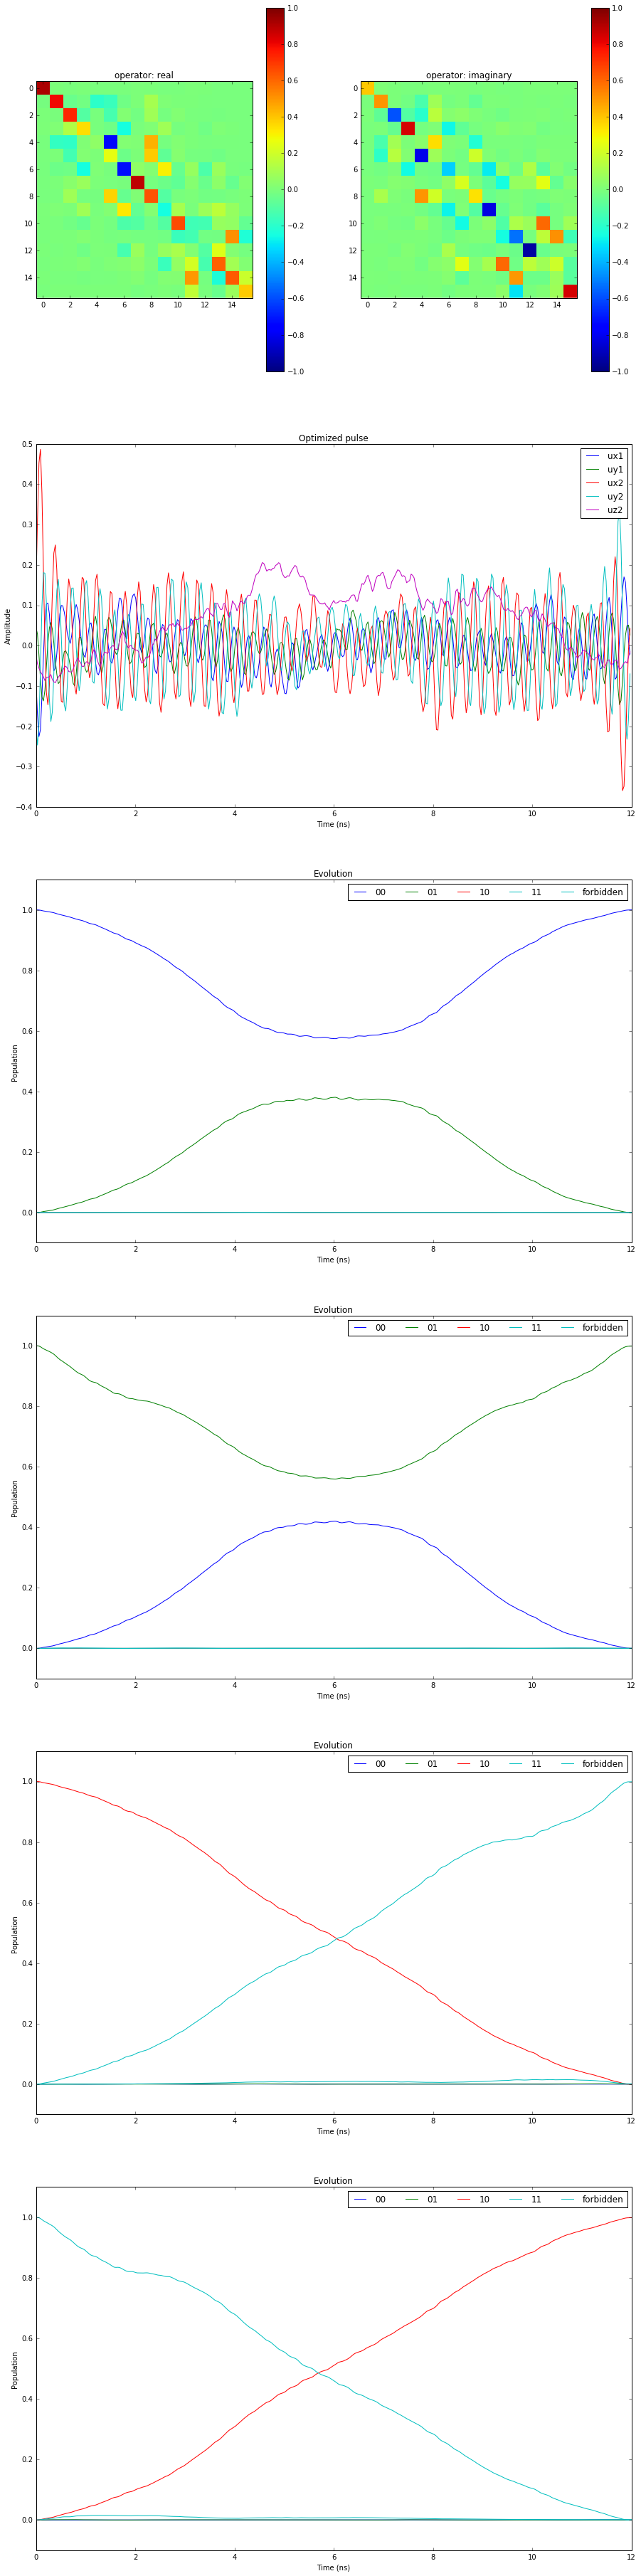

In [3]:
 #Extra options
#reg_coeffs = reg_coeffs,draw = [states_draw_list,states_draw_names] ,forbidden = states_forbidden_list,multi_mode = multi_mode,
#maxA = ops_max_amp,use_gpu = True
uks,U_f =Grape(H0,Hops,Hnames,U,total_time,steps,psi0,convergence=convergence, method = 'L-BFGS-B',switch=False, draw = [states_draw_list,states_draw_names] ,
               maxA = ops_max_amp, use_gpu=True, reg_coeffs=reg_coeffs, unitary_error = 1e-08, show_plots = False, dressed_info = dressed_info,
               file_name='transmon_transmon_CNOT', data_path = '/home/nelson/Simulations/GRAPE-Data/transmon_transmon_cnot')